<a href="https://colab.research.google.com/github/FuturisticLover123/InnowiseInternship/blob/main/task1/ETL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import boto3
from dotenv import load_dotenv
import io 
import pandas as pd

load_dotenv()

YC_ACCESS_KEY_ID = os.getenv("YC_ACCESS_KEY_ID")
YC_SECRET_ACCESS_KEY = os.getenv("YC_SECRET_ACCESS_KEY")
YC_ENDPOINT_URL = os.getenv("YC_ENDPOINT_URL")
YC_BUCKET_NAME = os.getenv("YC_BUCKET_NAME")

In [2]:
session = boto3.session.Session()
s3_client = session.client(
    service_name='s3',
    endpoint_url=YC_ENDPOINT_URL,
    aws_access_key_id=YC_ACCESS_KEY_ID,
    aws_secret_access_key=YC_SECRET_ACCESS_KEY
)

In [4]:
import gzip

file_names = ["item_categories.csv.gzip", "items.csv.gzip", "sales_train.csv.gzip", "sample_submission.csv.gzip", "shops.csv.gzip", "test.csv.gzip" ]
data_location = "compressed_data/"

data_storage = dict()
for file_name in file_names:
    response = s3_client.get_object(Bucket=YC_BUCKET_NAME, Key=f'{data_location}{file_name}')
    data_storage[file_name[: len(file_name) - 9]] = pd.read_csv(io.BytesIO(response['Body'].read()), compression='gzip')

In [5]:
train = data_storage["sales_train"]

In [6]:
%pip install pandas seaborn matplotlib numpy

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Note: you may need to restart the kernel to use updated packages.


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


Преобразуем дату из object в datetime

In [8]:
train['date'] = pd.to_datetime(train['date'], format = '%d.%m.%Y')

Целевая задача - предсказание продаж на магазинах из test поэтому глобально магазины из train которых нет в test нас не интересуют.<br>
Они будут создавать ненужные зависимости и повышать шум данных.<br>
Поэтому в целом их можно удалить 

In [9]:
train = train[data_storage["sales_train"]['shop_id'].isin((data_storage["test"])['shop_id'].unique())]
set(train["shop_id"].unique()).difference(set(data_storage["test"]["shop_id"].unique()))
# видно что все правильно удалилось

set()

In [10]:
filtered_train = train[(0 <= train['item_cnt_day'])]

удаляем отрицательные продажи тк это или ошибки при сборе данных или возвраты товаров<br>
в любом случае это не то что нам нужно

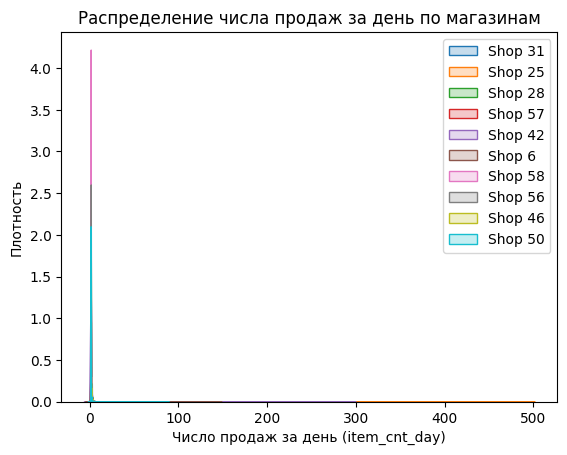

In [11]:
sample_shops = train['shop_id'].value_counts().index[:10]
for shop in sample_shops:
    sns.kdeplot(data=train[train['shop_id'] == shop], x='item_cnt_day', fill=True, label=f'Shop {shop}')
plt.title('Распределение числа продаж за день по магазинам')
plt.xlabel('Число продаж за день (item_cnt_day)')
plt.ylabel('Плотность')
plt.legend()
plt.show()

у разных магазинов разные пики в распределении продаж<br>
хочется удалять большие цифры с учетом этого 


In [12]:
def remove_outliers_by_shop(df, column='item_cnt_day'):
    cleaned_dfs = []
    for shop_id in df['shop_id'].unique():
        shop_data = df[df['shop_id'] == shop_id].copy()
        
        if len(shop_data) < 10:
            cleaned_dfs.append(shop_data)
            continue
        
        Q1 = shop_data[column].quantile(0.25)
        Q3 = shop_data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        shop_data_cleaned = shop_data[(shop_data[column] >= lower_bound) & 
                                      (shop_data[column] <= upper_bound)]
        
        cleaned_dfs.append(shop_data_cleaned)
    
    return pd.concat(cleaned_dfs, ignore_index=True)

sales_train_cleaned = remove_outliers_by_shop(data_storage["sales_train"], 'item_cnt_day')
print("Размер датасета после удаления выбросов:", sales_train_cleaned.shape)

print("Удалено строк:", len(data_storage["sales_train"]) - len(sales_train_cleaned))



Размер датасета после удаления выбросов: (2632181, 6)
Удалено строк: 303668


Мы потеряли 10% данных возможно это очень много 


In [13]:
%pip install scikit-learn
from sklearn.ensemble import IsolationForest  

Note: you may need to restart the kernel to use updated packages.


In [14]:
iso_forest = IsolationForest(contamination=0.01, random_state=42)
filtered_train['anomaly'] = iso_forest.fit_predict(filtered_train[['item_cnt_day']].values)
sales_train_cleaned = filtered_train[filtered_train['anomaly'] == 1].copy()

/tmp/ipykernel_95098/2429495425.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_train['anomaly'] = iso_forest.fit_predict(filtered_train[['item_cnt_day']].values)


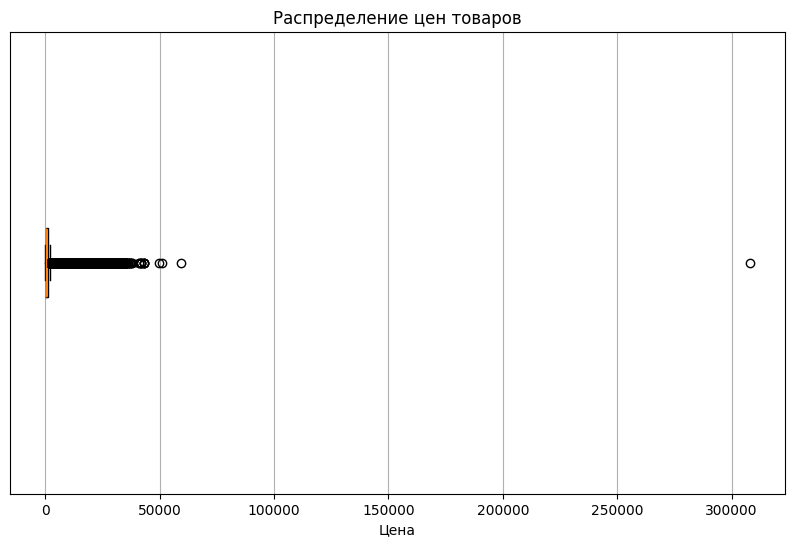

In [16]:
plt.figure(figsize=(10, 6))
plt.boxplot(sales_train_cleaned['item_price'], vert=False)
plt.title('Распределение цен товаров')
plt.xlabel('Цена')
plt.yticks([])
plt.grid(True)

Видно наличие аномалий 

In [17]:
upper_quantile = sales_train_cleaned['item_price'].quantile(0.99)
sales_train_filtered = sales_train_cleaned[sales_train_cleaned['item_price'] <= upper_quantile]


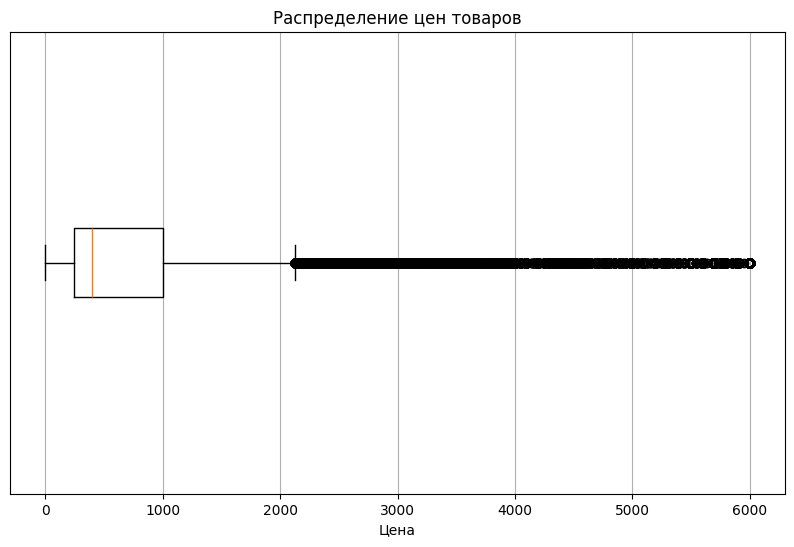

In [18]:
plt.figure(figsize=(10, 6))
plt.boxplot(sales_train_filtered['item_price'], vert=False)
plt.title('Распределение цен товаров')
plt.xlabel('Цена')
plt.yticks([])
plt.grid(True)

Естественно что большинство товаров дешевые <br>
Поэтому стало лучше

<Axes: xlabel='item_price', ylabel='Density'>

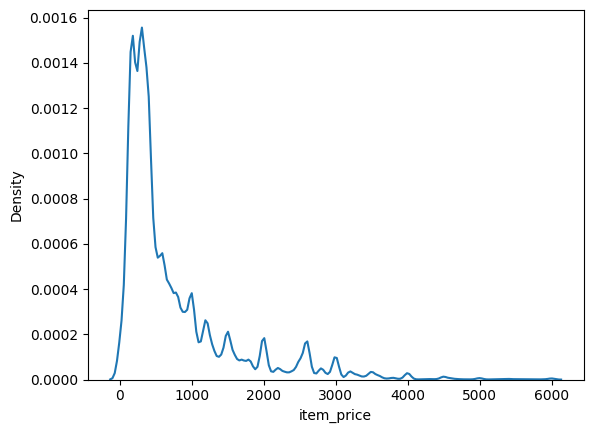

In [19]:
sns.kdeplot(sales_train_filtered['item_price'])
# стало сильно лучше 

In [20]:
sales_train_filtered.drop(columns=['anomaly'], inplace=True)

/tmp/ipykernel_95098/3443905947.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_train_filtered.drop(columns=['anomaly'], inplace=True)


Была проведена очиста данных от аномалий.<br>
Проверены связи в данных.


# Выгрузка данных

In [22]:
directory = "filtered_data/"


buffer = io.BytesIO()
sales_train_filtered.to_csv(buffer, index=False, compression='gzip')
    
buffer.seek(0)


s3_client.upload_fileobj(buffer, YC_BUCKET_NAME, f"{directory}train.csv.gzip")
